# 基础环境准备

In [ ]:
!pip install cantera
from nondim import x0, P0, T0, t0
import janc.thermo as thermo
import janc.boundary as boundary
import janc.aux_func as aux_func
import janc.solver as solver
import cantera as ct
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from tqdm.auto import tqdm

# 设置JAX使用GPU
jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'gpu')

# 边界条件和自定义源项设置

In [ ]:
Lx = 0.05/x0
Ly = 0.0125/x0

nx = 4000
ny = 1000


In [ ]:
def boundary_conditions(U,aux):
    # 左右虚网格镜像反射（无滑移）
    U = jnp.concatenate([U,aux],axis=0)
    left_ghost = jnp.concatenate([U[:,0:1,:],U[:,0:1,:],U[:,0:1,:]],axis=1)
    left_ghost = left_ghost.at[1].multiply(-1)  # 速度反向

    right_ghost = jnp.concatenate([U[:,-1:,:],U[:,-1:,:],U[:,-1:,:]],axis=1)
    right_ghost = right_ghost.at[1].multiply(-1)

    U_with_ghost = jnp.concatenate([left_ghost, U, right_ghost], axis=1)

    # 上下虚网格镜像反射（无滑移）
    lower_ghost = jnp.concatenate([U_with_ghost[:,:,0:1],U_with_ghost[:,:,0:1],U_with_ghost[:,:,0:1]],axis=2)
    lower_ghost = lower_ghost.at[2].multiply(-1)  # v 反向

    upper_ghost = jnp.concatenate([U_with_ghost[:,:,-1:],U_with_ghost[:,:,-1:],U_with_ghost[:,:,-1:]],axis=2)
    upper_ghost = upper_ghost.at[2].multiply(-1)

    U_with_ghost = jnp.concatenate([lower_ghost, U_with_ghost, upper_ghost], axis=2)

    return U_with_ghost[0:-2],U_with_ghost[-2:]

# 计算

In [ ]:

grid_set = {'Lx':Lx,'Ly':Ly,'nx':nx,'ny':ny}

thermo_set = {'is_detailed_chemistry':True,
          'chemistry_mechanism_diretory':'chem.txt',
          'thermo_model':'nasa7',
          'nasa7_mech':'gri30.yaml'}

boundary_set = {'boundary_conditions':boundary_conditions}
source_set = {'self_defined_source_terms':None}

In [ ]:
#在完成边界和源项设置后，就可以引入求解器
time_step, _, _ = solver.set_solver(thermo_set,boundary_set,source_set,'base')

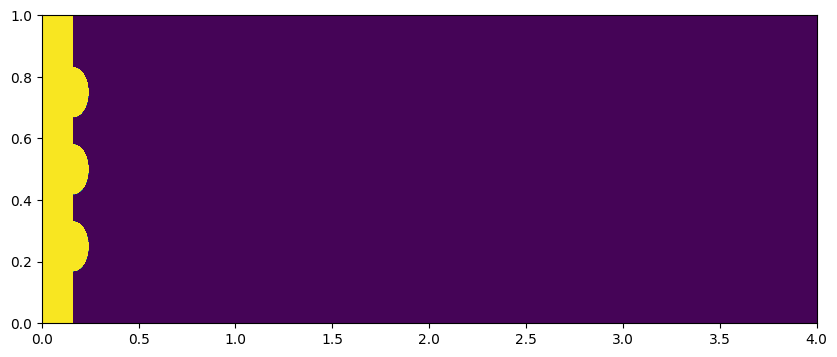

In [ ]:
ratio = 1.0
yH2inj = (ratio/8*0.232)/(1 + ratio/8*0.232)
yO2inj = 0.232/(1 + ratio/8*0.232)

def initial_conditions(ignition_width,ignition_height):
    Penv = 1.0*101325/P0; Tenv = 300/T0; yH2env = 0.028; yO2env = 0.226; # 用于爆震管仿真工况【初始流场条件】
    # Penv = 1*101325/P0; Tenv = 300/T0; yH2env = 0; yO2env = 0.226; # 用于二维RDE仿真工况【初始流场条件】
    Pignition = 75*101325/P0; Tignition = 3500/T0; Tfill = T0/T0; # 用于二维RDE工况【点火区域】【点火温度可以试着适当放小一点】
    Yenv = jnp.concatenate([jnp.array([yH2env,yO2env]),1e-20*jnp.ones(8-2)])
    Yfill = jnp.concatenate([jnp.array([yH2inj,yO2inj]),1e-20*jnp.ones(8-2)])
    _,gamma_env,h_env,Renv,_ = thermo.get_thermo(jnp.array([[[Tenv]]]),jnp.expand_dims(Yenv,(1,2)))
    _,gamma_ignition,h_ignition,_,_ = thermo.get_thermo(jnp.array([[[Tignition]]]),jnp.expand_dims(Yfill,(1,2)))
    _,gamma_fill,h_fill,Rfill,_ = thermo.get_thermo(jnp.array([[[Tfill]]]),jnp.expand_dims(Yfill,(1,2)))

    gamma_env = gamma_env.squeeze()
    h_env = h_env.squeeze()
    Renv = Renv.squeeze()
    gamma_ignition = gamma_ignition.squeeze()
    h_ignition = h_ignition.squeeze()
    gamma_fill = gamma_fill.squeeze()
    h_fill = h_fill.squeeze()
    Rfill = Rfill.squeeze()

    rho_init = Penv/(Renv*Tenv)*jnp.ones((nx,ny))
    rhou_init = jnp.zeros((nx,ny))
    rhov_init = jnp.zeros((nx,ny))
    E_init = (Penv/(Renv*Tenv)*h_env - Penv)*jnp.ones((nx,ny))
    T_init = (Tenv)*jnp.ones((nx,ny))
    gamma_init = (gamma_env)*jnp.ones((nx,ny))
    rhoY_init = jnp.expand_dims(Penv/(Renv*Tenv)*Yenv,(1,2))*jnp.ones((8,nx,ny))


    div = 2
    rho_init = rho_init.at[0:ignition_width,0:ignition_height].set(Pignition/(Rfill*Tignition))
    E_init = E_init.at[0:ignition_width,0:ignition_height].set(Pignition/(Rfill*Tignition)*h_ignition - Pignition)
    T_init = T_init.at[0:ignition_width,0:ignition_height].set(Tignition)
    gamma_init = gamma_init.at[0:ignition_width,0:ignition_height].set(gamma_ignition)
    value = jnp.expand_dims(rho_init[0:ignition_width,0:ignition_height],0)*jnp.tile(jnp.expand_dims(Yfill,(1,2)),(1,ignition_width,ignition_height))
    rhoY_init = rhoY_init.at[:,0:ignition_width,0:ignition_height].set(value)

    # 适用于爆震管仿真：增加局部爆点诱导胞格
    temp_x = jnp.linspace(0, nx, nx)
    temp_y = jnp.linspace(0, ny, ny)
    temp_x, temp_y = jnp.meshgrid(temp_y, temp_x)
    radius = ignition_width//2

    distance_1 = jnp.sqrt((temp_y - ignition_width)**2 + (temp_x - ignition_height//4)**2)
    distance_2 = jnp.sqrt((temp_y - ignition_width)**2 + (temp_x - ignition_height//4)**2)
    distance_3 = jnp.sqrt((temp_y - ignition_width)**2 + (temp_x - ignition_height//2)**2)
    distance_4 = jnp.sqrt((temp_y - ignition_width)**2 + (temp_x - (ignition_height//4)*3)**2)
    distance_5 = jnp.sqrt((temp_y - ignition_width)**2 + (temp_x - (ignition_height//4)*3)**2)

    mask = (distance_1 <= radius) | (distance_2 <= radius) | (distance_3 <= radius) | (distance_4 <= radius) | (distance_5 <= radius)
    rho_init = rho_init.at[mask].set(Pignition/(Rfill*Tignition))
    E_init = E_init.at[mask].set(Pignition/(Rfill*Tignition)*h_ignition - Pignition)
    T_init = T_init.at[mask].set(Tignition)
    gamma_init = gamma_init.at[mask].set(gamma_ignition)

    new_rhoY = rho_init * Yfill[:, None, None]  # 广播乘法
    rhoY_init = jnp.where(mask[None, :, :], new_rhoY, rhoY_init)

    # 遍历所有网格点，修改满足 mask 条件的点的组分信息 【这段代码写的不好，没有优化，执行时间太长了】
    #for i in range(ignition_width+radius):
    #  for j in range(ny):
    #    if mask[i, j]:  # 如果当前网格点满足 mask 条件
    #      rhoY_init[:, i, j] = rho_init[i,j] * Yfill  # 将组分信息设置为 Yfill，并乘以当前网格点的密度

    rho_init = jnp.expand_dims(rho_init,0)
    rhou_init = jnp.expand_dims(rhou_init,0)
    rhov_init = jnp.expand_dims(rhov_init,0)
    E_init = jnp.expand_dims(E_init,0)
    state_init = jnp.concatenate([rho_init,rhou_init,rhov_init,E_init,rhoY_init],axis=0)
    return jnp.concatenate([jnp.array(state_init),jnp.array([gamma_init]),jnp.array([T_init])],axis=0)


ignition_width = 80*2;ignition_height = 500*2
U = initial_conditions(ignition_width,ignition_height)
plt.figure(figsize=(10, 4))
x = jnp.linspace(0, Lx, nx)
y = jnp.linspace(0, Ly, ny)
X, Y = jnp.meshgrid(x, y, indexing='ij')
plt.contourf(X, Y, U[-1], levels=50, cmap='viridis')

In [ ]:
nt = 20000
saved_T = []
for step in tqdm(range(nt), desc="计算进度", unit="step"):
    U = time_step(U,Lx/nx,Ly/ny,5e-10/t0)
    if (step+1)%100 == 0:
      saved_T.append(U[-1])

计算进度:   0%|          | 0/20000 [00:00<?, ?step/s]

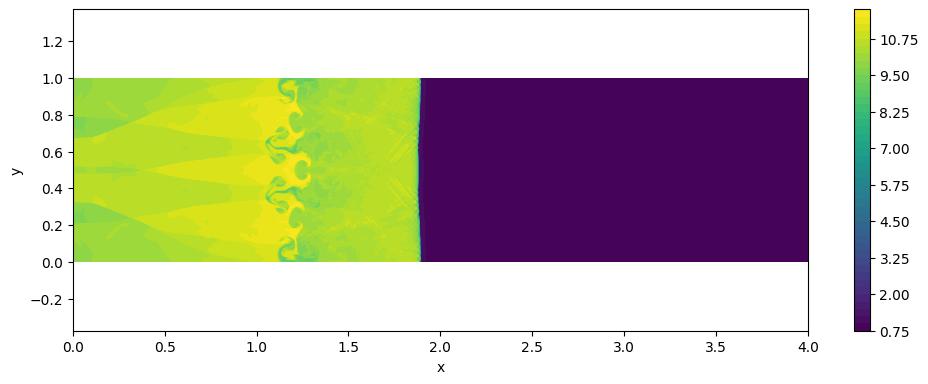

In [ ]:
plt.figure(figsize=(10, 4))
plt.contourf(X, Y, saved_T[-1], levels=50, cmap='viridis')
#plt.clim(0, 4)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.tight_layout()
plt.axis('equal')
plt.show()

In [ ]:
T_np = np.array(saved_T)

GIF保存完成！


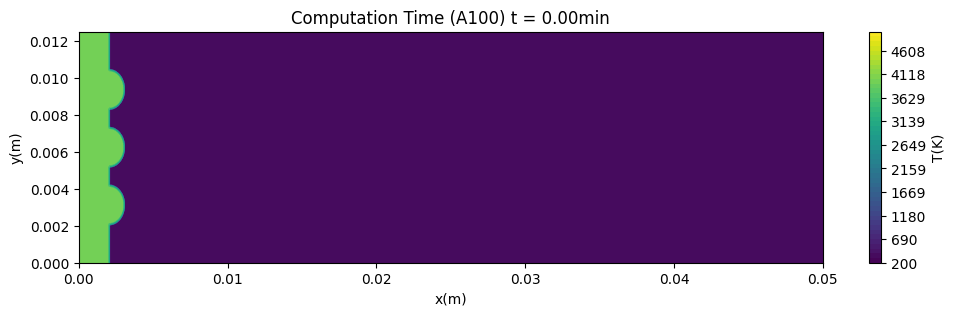

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 假设你的数据形状为 (nt, nx, ny)，这里生成示例数据
nt, nx, ny = 200, 4000, 1000
data = 300*T_np



# 初始化图形
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title("Frame 0")

# 首帧绘图（注意转置数据维度）
levels = np.linspace(200.0, 5000.0, 50)

contour = ax.contourf(X*x0, Y*x0, data[0], levels=levels, cmap='viridis', vmin=200.0, vmax=5000.0)
cbar = fig.colorbar(contour)
cbar.set_label('T(K)')
ax.set_xlabel('x(m)')
ax.set_ylabel('y(m)')

def update(frame):
    """动画更新函数"""
    # 清除旧的图形元素（优化版）
    for coll in ax.collections:  # 遍历所有图形集合
        coll.remove()           # 安全移除元素
    ax.contourf(X*x0, Y*x0, data[frame], levels=levels, cmap='viridis', vmin=200.0, vmax=5000.0)
    time = frame*100/5.03/60
    ax.set_title(f"Computation Time (A100) t = {time:.2f}min")
    return ax.collections       # 返回当前所有图形集合

# 创建动画对象
anim = FuncAnimation(fig, update, frames=nt, interval=100)

# 保存为GIF（需安装pillow库）
anim.save("/content/drive/MyDrive/animation5.gif", writer="pillow", fps=24, dpi=100)

print("GIF保存完成！")